In [2]:
# Importing the libraries

import numpy as np
import pandas as pd
import datetime
from sklearn.cluster import KMeans
import collections
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from validclust import dunn
from sklearn.cluster import AgglomerativeClustering
import scipy
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
%matplotlib notebook

<h3>Data Preprocessing</h3>

To have a better understanding of the outcome and to reduce the complexity of the problem at hand, we'll be working with only the english fraction of our dataset which comprises of more than 70% of our original data

In [3]:
tweets_data = pd.read_csv('D:/Lectures/DM/HW6/tweets_en.csv')

In [5]:
tweets_data

,index,user,timestamp,replies,likes,retweets,text,tweet_lang
0,1,bitcointe,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...,en
1,2,3eyedbran,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...,en
2,3,DetroitCrypto,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,en
3,4,mmursaleen72,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,en
4,6,evilrobotted,2019-05-27 11:49:25+00,0.0,0.0,0.0,@nwoodfine We have been building on the real #...,en
...,...,...,...,...,...,...,...,...
13451591,20606868,digital_mine_,2019-11-23 15:45:55+00,0.0,0.0,0.0,Daily profit for HODLING BTC since 2013 Data t...,en
13451592,20606869,JacobCanfield,2019-11-23 15:28:50+00,2.0,16.0,3.0,Happy #FibonacciDay \n\nA while back I created...,en
13451593,20606871,torusJKL,2019-11-23 15:45:56+00,0.0,0.0,0.0,Register now for the early access of the Codug...,en
13451594,20606872,Adekunl95628158,2019-11-23 15:45:57+00,0.0,0.0,0.0,@btc \n@btc \nDo you know that BTC Baskets isn...,en


Since we are going to be grouping data into clusters, we won't be needing the tweet text for this task and tweet_lang was made redundant the moment we decided to work with only english tweets so we'll discard these two columns

In [6]:
tweets_text = tweets_data['text']

In [7]:
tweets_data = tweets_data.drop('text',axis=1)

In [8]:
tweets_data

,index,user,timestamp,replies,likes,retweets,tweet_lang
0,1,bitcointe,2019-05-27 11:49:18+00,0.0,0.0,0.0,en
1,2,3eyedbran,2019-05-27 11:49:06+00,0.0,2.0,1.0,en
2,3,DetroitCrypto,2019-05-27 11:49:22+00,0.0,0.0,0.0,en
3,4,mmursaleen72,2019-05-27 11:49:23+00,0.0,0.0,0.0,en
4,6,evilrobotted,2019-05-27 11:49:25+00,0.0,0.0,0.0,en
...,...,...,...,...,...,...,...
13451591,20606868,digital_mine_,2019-11-23 15:45:55+00,0.0,0.0,0.0,en
13451592,20606869,JacobCanfield,2019-11-23 15:28:50+00,2.0,16.0,3.0,en
13451593,20606871,torusJKL,2019-11-23 15:45:56+00,0.0,0.0,0.0,en
13451594,20606872,Adekunl95628158,2019-11-23 15:45:57+00,0.0,0.0,0.0,en


Moving forward, we have data that dates way back than 2016, we want to eliminate those as well so that there are fewer outliers

In [9]:
tweets_data['date'] = pd.to_datetime(tweets_data['timestamp']).dt.date
tweets_data.sort_values(by=['date'], axis=0, inplace=True, ignore_index=True)
tweets_data.reset_index(inplace=True, drop=True)
tweets_data = tweets_data[
         (tweets_data['date']>=datetime.datetime.strptime('2016-01-01', '%Y-%m-%d').date())&
         (tweets_data['date']<=datetime.datetime.strptime('2019-03-29', '%Y-%m-%d').date())
     ].reset_index(drop=True)

In [10]:
tweets_data

,index,user,timestamp,replies,likes,retweets,tweet_lang,date
0,2034184,ProjectCoin,2016-01-01 07:54:18+00,0.0,0.0,1.0,en,2016-01-01
1,2034183,ProjectCoin,2016-01-01 08:29:20+00,0.0,0.0,1.0,en,2016-01-01
2,2034159,BTCtoUSD,2016-01-01 04:20:03+00,0.0,0.0,1.0,en,2016-01-01
3,2034182,BTCtoUSD,2016-01-01 09:00:06+00,0.0,0.0,0.0,en,2016-01-01
4,2034177,BTCticker,2016-01-01 12:00:04+00,0.0,0.0,0.0,en,2016-01-01
...,...,...,...,...,...,...,...,...
2334680,2837817,nctmurkli,2019-03-29 22:00:38+00,0.0,0.0,0.0,en,2019-03-29
2334681,2837814,swonhoc,2019-03-29 12:00:49+00,0.0,0.0,0.0,en,2019-03-29
2334682,2869857,btcandfriends,2019-03-29 17:45:27+00,42.0,353.0,144.0,en,2019-03-29
2334683,12200142,TheCryptoWoIf,2019-03-29 07:18:44+00,14.0,4287.0,2266.0,en,2019-03-29


Next, we want to have our data aggregated on user level so before we actually start grouping the data in clusters 

In [11]:
agg_tweets = tweets_data.groupby(by='user').sum()

In [12]:
agg_tweets

,index,replies,likes,retweets
user,,,,
000000000OOK,14120565,1.0,0.0,0.0
0000Marcos0,6967535,0.0,1.0,0.0
0000ZHUMA,6941013,0.0,0.0,0.0
0000derek,6622929,1.0,1.0,0.0
00015Rajesh,19911729,0.0,0.0,0.0
...,...,...,...,...
zzz12121212zzz,26274320,0.0,0.0,0.0
zzz25zzz,1172427220,2.0,16.0,1.0
zzzgodszzz,84638261,18.0,8.0,1.0


The table demonstrates that we have 289414 unique users who contributed through their likes, tweets and reposts to the whole data

<h3>Feature Selection</h3>

In [13]:
training_data = agg_tweets.iloc[:,[1,2,3]]

In [14]:
training_data

,replies,likes,retweets
user,,,
000000000OOK,1.0,0.0,0.0
0000Marcos0,0.0,1.0,0.0
0000ZHUMA,0.0,0.0,0.0
0000derek,1.0,1.0,0.0
00015Rajesh,0.0,0.0,0.0
...,...,...,...
zzz12121212zzz,0.0,0.0,0.0
zzz25zzz,2.0,16.0,1.0
zzzgodszzz,18.0,8.0,1.0


For Clustering, we are going by the assumption that we don't know how many categories our Data is going to have so let's assume that the value of K is unknown to us and then proceed to Clustering

<h2>K-means Clustering</h2>

In K-means Clustering, every data point is assigned a cluster through reducing the in-cluster sum of squares i.e. the algorithm identifies k number of centroids and then allocates every data point to the nearest cluster while keeping the centroid as small as possible

To get the ideal value of K we are performing an elbow method approach where we use distortion and inertia as metrics

In [21]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(np.array(training_data))
    kmeanModel.fit(np.array(training_data))
  
    distortions.append(sum(np.min(cdist(np.array(training_data), kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / np.array(training_data).shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(np.array(training_data), kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / np.array(training_data).shape[0]
    mapping2[k] = kmeanModel.inertia_

In [22]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 73.28326727247898
2 : 59.13095092323044
3 : 49.75159256456432
4 : 48.5731945130259
5 : 44.04188746142412
6 : 33.94351294004488
7 : 32.95510235993768
8 : 32.64553336607627
9 : 29.70041470576785


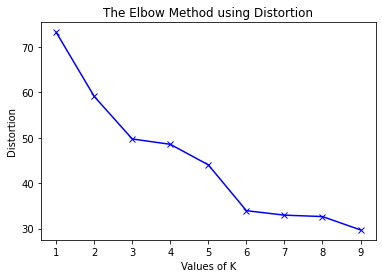

In [23]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [24]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 536085747863.40436
2 : 221548650586.6468
3 : 146432192214.37027
4 : 101886927110.96075
5 : 64058947639.852936
6 : 48871789180.54158
7 : 35495444850.75738
8 : 29664988710.933903
9 : 24843534777.464226


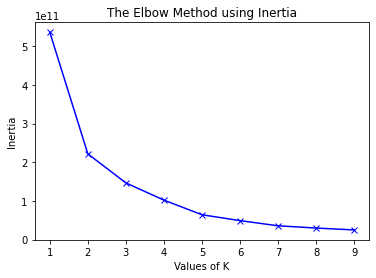

In [25]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

As you can see from the elbow curve of both the distortion and inertia, we get the steepest curve around k=3

<b>Conclusion:</b> From this, we can infer that our data has three possible output labels category, there are users who positively affect the price then their are users who negatively affect the price and finally there are those who have no effect on the price

In [15]:
kmeans = KMeans(n_clusters=3).fit(np.array(training_data))

In [17]:
gg = collections.Counter(kmeans.labels_)

In [18]:
print(gg)

Counter({0: 289331, 2: 72, 1: 11})


In [19]:
centroids = kmeans.cluster_centers_

<h2>Hierarchial Clustering</h2>

The Hierarchial Clustering algorithm groups similar objects into groups called clusters. The endpoint is a set of clusters or groups, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other.

We are going to start with Agglomerative Hierarchial Clustering which is a bottom-up approach and it works in the following manner-<br>
1. Make each data point a single-point cluster → forms N clusters<br>
2. Take the two closest data points and make them one cluster → forms N-1 clusters<br>
3. Take the two closest clusters and make them one cluster → Forms N-2 clusters<br>
4. Repeat step-3 until you are left with only one cluster<br>

The Algorithm is running out of memory when we try to feed it the entierity of our dataset so we have to work with a fraction of our data, so the largest workable fraction of data that I found was 1% of the original data i.e. 2894 samples 

In [15]:
gg = training_data.iloc[:2894]

In [16]:
Z = scipy.cluster.hierarchy.linkage(gg, 'ward')

<IPython.core.display.Javascript object>


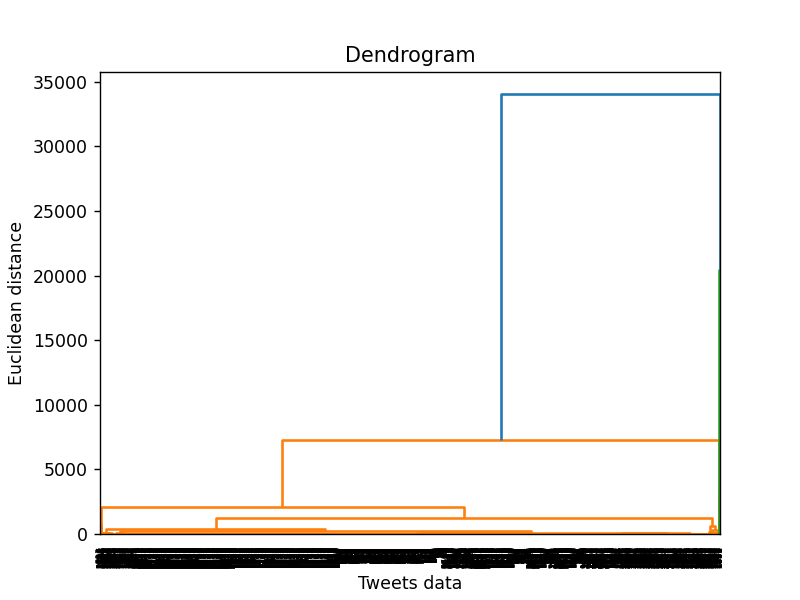

In [15]:
#dendrogrm = sch.dendrogram(sch.linkage(gg), method = 'ward')
dendogram = sch.dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Tweets data')
plt.ylabel('Euclidean distance')
plt.show()

In [17]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(gg)

In [18]:
print(collections.Counter(y_hc))

Counter({0: 2891, 1: 2, 2: 1})


In [19]:
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(gg)

In [20]:
print(collections.Counter(y_hc))

Counter({1: 2891, 0: 3})


In [23]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(gg)

In [24]:
print(collections.Counter(y_hc))

Counter({1: 2888, 0: 3, 3: 2, 2: 1})


<b>Conclusion:</b>: Looking at the results of various number of clusters and the dendrogram we can observe that according to Hierarchial Clustering there's only a single cluster in our data but this could also be because we are only working with a very small fraction of our data and there is a possibility that all of our data inside the fraction belongs to a single class

<h2>DBSCAN Clustering</h2>

DBSCAN is a density Based Clustering algorithm that employs the usage of two parameters, Epsilon for determining the maximum distance allowed between two points within a cluster and the second one is minimum samples which is the minimum number of neighbors contained within a cluster with radius of Epsilon

You can see that here, we have to determine the value of Epsilon and Min_samples instead of K and to do that we follow a set of general rules of thumb

1] For 2-D Dimensional data, DBSCAN'S Default Min_sample value would be 2<br>
2] If your data has more than 2 dimensions, Min_sample = 2*Data dimensions (Sander et al., 1998)<br>
3] Feed K=Min_sample to KNN and calculate the average distance between each point and it's K neighbors<br>
4] Sort the K-distances and Plot a graph in ascending order<br>
5] The optimal value for epsilon is determined at the maximum point of curvature in our graph<br>

When we try to feed the whole data as input to the dbscan algorithm, it runs out of memory so we have to feed it a fraction of our original data, 10% of our data to be precise

In [25]:
data_fraction_1 = training_data.iloc[:28941]

In [26]:
data_fraction_1

,replies,likes,retweets
user,,,
000000000OOK,1.0,0.0,0.0
0000Marcos0,0.0,1.0,0.0
0000ZHUMA,0.0,0.0,0.0
0000derek,1.0,1.0,0.0
00015Rajesh,0.0,0.0,0.0
...,...,...,...
ChartingChris,1.0,0.0,0.0
ChartingWealth,0.0,0.0,0.0
Chartingsecrets,0.0,1.0,0.0


In [17]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(data_fraction_1)
distances, indices = neighbors_fit.kneighbors(data_fraction_1)

<IPython.core.display.Javascript object>


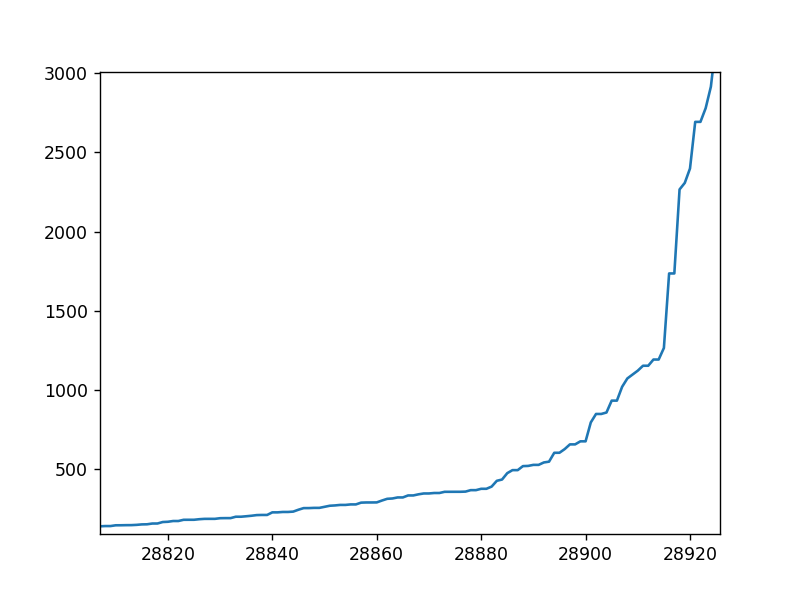

In [18]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

We can see that the maximum curvature is between the range 250-750 so we'll try all these epsilon values.

We are using two different evaluation metrics for determining the performance of DBSCAN, Silhouette score and DB Index

In [19]:
sihouette_eps_val = {}
DB_Index = {}
Noise_per_eps = {}

for i in range(250,750,25):
    db = DBSCAN(eps=i, min_samples=6).fit(data_fraction_1)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    gg = collections.Counter(labels)
    ss = silhouette_score(data_fraction_1,db.labels_)
    dd = davies_bouldin_score(data_fraction_1,db.labels_)
    sihouette_eps_val[i] = ss
    DB_Index[i] = dd
    Noise_per_eps[i] = gg[-1]
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("For Epsilon value {}, the number of clusters we get are {}".format(i,n_clusters_))

For Epsilon value 250, the number of clusters we get are 3
For Epsilon value 275, the number of clusters we get are 2
For Epsilon value 300, the number of clusters we get are 1
For Epsilon value 325, the number of clusters we get are 1
For Epsilon value 350, the number of clusters we get are 1
For Epsilon value 375, the number of clusters we get are 2
For Epsilon value 400, the number of clusters we get are 2
For Epsilon value 425, the number of clusters we get are 2
For Epsilon value 450, the number of clusters we get are 3
For Epsilon value 475, the number of clusters we get are 3
For Epsilon value 500, the number of clusters we get are 3
For Epsilon value 525, the number of clusters we get are 3
For Epsilon value 550, the number of clusters we get are 3
For Epsilon value 575, the number of clusters we get are 3
For Epsilon value 600, the number of clusters we get are 4
For Epsilon value 625, the number of clusters we get are 4
For Epsilon value 650, the number of clusters we get are

In [21]:
max(sihouette_eps_val, key=sihouette_eps_val.get)

700

In [23]:
min(DB_Index, key=DB_Index.get)

700

In [25]:
min(Noise_per_eps, key=DB_Index.get)

700

Moving on, we'll try the next fraction of data

In [37]:
data_fraction_2 = training_data.iloc[28941:28941+28941]

In [38]:
data_fraction_2

,replies,likes,retweets
user,,,
ChartofWar,26.0,79.0,2.0
Charts4bitcoin,0.0,8.0,0.0
ChartsAnon,0.0,0.0,0.0
ChartsBtc,38.0,899.0,297.0
ChartsCrypto,21.0,39.0,4.0
...,...,...,...
GaleGideon,0.0,0.0,0.0
GalenResty,1.0,8.0,2.0
Galeo_Ve,0.0,0.0,0.0


<IPython.core.display.Javascript object>


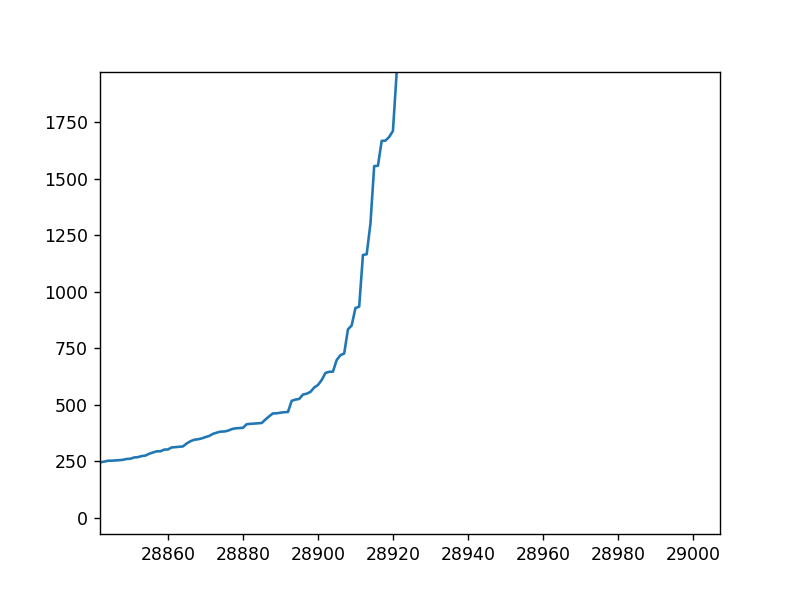

In [32]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(data_fraction_1)
distances, indices = neighbors_fit.kneighbors(data_fraction_2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [39]:
sihouette_eps_val = {}
DB_Index = {}
Noise_per_eps = {}

for i in range(300,850,25):
    db = DBSCAN(eps=i, min_samples=6).fit(data_fraction_2)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    gg = collections.Counter(labels)
    ss = silhouette_score(data_fraction_1,db.labels_)
    dd = davies_bouldin_score(data_fraction_1,db.labels_)
    sihouette_eps_val[i] = ss
    DB_Index[i] = dd
    Noise_per_eps[i] = gg[-1]
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("For Epsilon value {}, the number of clusters we get are {}".format(i,n_clusters_))

For Epsilon value 300, the number of clusters we get are 2
For Epsilon value 325, the number of clusters we get are 2
For Epsilon value 350, the number of clusters we get are 1
For Epsilon value 375, the number of clusters we get are 1
For Epsilon value 400, the number of clusters we get are 1
For Epsilon value 425, the number of clusters we get are 1
For Epsilon value 450, the number of clusters we get are 1
For Epsilon value 475, the number of clusters we get are 1
For Epsilon value 500, the number of clusters we get are 1
For Epsilon value 525, the number of clusters we get are 1
For Epsilon value 550, the number of clusters we get are 1
For Epsilon value 575, the number of clusters we get are 1
For Epsilon value 600, the number of clusters we get are 1
For Epsilon value 625, the number of clusters we get are 1
For Epsilon value 650, the number of clusters we get are 1
For Epsilon value 675, the number of clusters we get are 1
For Epsilon value 700, the number of clusters we get are

In [40]:
max(sihouette_eps_val, key=sihouette_eps_val.get)

825

In [41]:
min(DB_Index, key=DB_Index.get)

350

In [42]:
min(Noise_per_eps, key=DB_Index.get)

350

Let's try with random samples of our data now-

In [30]:
data_fraction_3 = training_data.sample(frac=0.10)

In [31]:
data_fraction_3

,replies,likes,retweets
user,,,
giaim00,1.0,1.0,0.0
realKabutops,0.0,1.0,0.0
solasalami,0.0,1.0,0.0
leduycr79,0.0,0.0,0.0
axelk,5.0,5.0,0.0
...,...,...,...
markhanderson,0.0,0.0,0.0
philmillo,1.0,1.0,0.0
charmcityjs,0.0,2.0,0.0


<IPython.core.display.Javascript object>


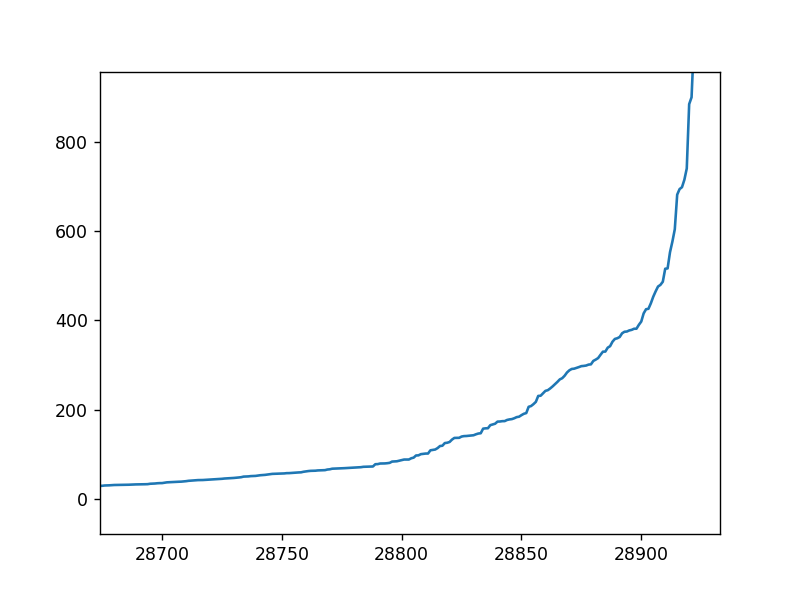

In [32]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(data_fraction_1)
distances, indices = neighbors_fit.kneighbors(data_fraction_3)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [33]:
sihouette_eps_val = {}
DB_Index = {}
Noise_per_eps = {}

for i in range(250,750,25):
    db = DBSCAN(eps=i, min_samples=6).fit(data_fraction_3)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    gg = collections.Counter(labels)
    ss = silhouette_score(data_fraction_3,db.labels_)
    dd = davies_bouldin_score(data_fraction_3,db.labels_)
    sihouette_eps_val[i] = ss
    DB_Index[i] = dd
    Noise_per_eps[i] = gg[-1]
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("For Epsilon value {}, the number of clusters we get are {}".format(i,n_clusters_))

For Epsilon value 250, the number of clusters we get are 1
For Epsilon value 275, the number of clusters we get are 1
For Epsilon value 300, the number of clusters we get are 1
For Epsilon value 325, the number of clusters we get are 3
For Epsilon value 350, the number of clusters we get are 3
For Epsilon value 375, the number of clusters we get are 3
For Epsilon value 400, the number of clusters we get are 3
For Epsilon value 425, the number of clusters we get are 1
For Epsilon value 450, the number of clusters we get are 1
For Epsilon value 475, the number of clusters we get are 1
For Epsilon value 500, the number of clusters we get are 1
For Epsilon value 525, the number of clusters we get are 1
For Epsilon value 550, the number of clusters we get are 1
For Epsilon value 575, the number of clusters we get are 1
For Epsilon value 600, the number of clusters we get are 1
For Epsilon value 625, the number of clusters we get are 1
For Epsilon value 650, the number of clusters we get are

In [34]:
max(sihouette_eps_val, key=sihouette_eps_val.get)

725

In [35]:
min(DB_Index, key=DB_Index.get)

725

In [36]:
min(Noise_per_eps, key=DB_Index.get)

725

<b>Coclusion:</b> DBSCAN Gave us quite conflicting results for these data samples, as it suggests that no matter what data we choose, we are bound to get only one optimal cluster as evident from the data samples that we chose and the metrics that we used for evaluation and for our second data fraction you can see that silhouette metrics and DB_Index are producing different results

    Overall we can conclude saying that in the context of this dataset, the results were we obtained through clustering are not very reliable as each type of clustering produced a different outcome i.e. gave different number of clusters in response, only K-means clustering gave us results that may have made sense.
    Moreover, Grouping tweets solely on the basis of likes, retweets and comments is a difficult task without the context of the actual tweet text at least with clustering as there with a lack of strong asossication between the bitcoin stock price and the combination of likes,retweets and comments.

    One possible reasons as to why the clustering won't make that much sense with this data is because a user can have multiple effects on the price of bitcoin stock through their tweets so the question remains when we choose to aggregate data on the user level, what group would the user belong to?

<h2>References:-</h2>

https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1#:~:text=Every%20data%20point%20is%20allocated,centroids%20as%20small%20as%20possible.

https://medium.com/@tarammullin/dbscan-2788cfce9389

https://www.kdnuggets.com/2019/09/hierarchical-clustering.html